<a href="https://colab.research.google.com/github/adventuresinML/adventures-in-ml-code/blob/master/tensorflow_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

     |████████████████████████████████| 79.9MB 3.6MB/s 
     |████████████████████████████████| 419kB 50.6MB/s 
     |████████████████████████████████| 61kB 28.0MB/s 
     |████████████████████████████████| 3.0MB 41.0MB/s 


#### Install NGROK to provide a tunnel for TensorBoard utilization

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-06-07 22:13:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.4.95.48, 34.232.40.183, 52.3.53.115, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.4.95.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  61.3MB/s    in 0.3s    

2019-06-07 22:13:10 (61.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pylab as plt

In [0]:
split = (80, 10, 10)
splits = tfds.Split.TRAIN.subsplit(weighted=split)

(cat_train, cat_valid, cat_test), info = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

W0607 22:13:44.561256 140573943474048 cats_vs_dogs.py:107] 1738 images were corrupted and were skipped


W0607 22:13:44.599093 140573943474048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:264: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


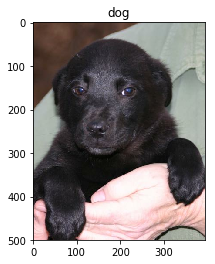

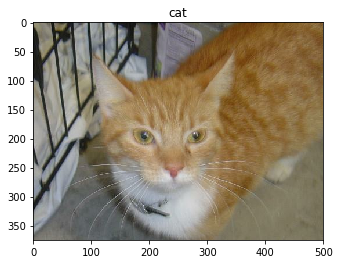

In [0]:
get_label_name = info.features['label'].int2str
for image, label in cat_test.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))
  image_ = image

In [0]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

In [0]:
TRAIN_BATCH_SIZE = 64
cat_train = cat_train.map(pre_process_image).shuffle(1000).repeat().batch(TRAIN_BATCH_SIZE)
cat_valid = cat_valid.map(pre_process_image).repeat().batch(1000)

In [0]:
head = tf.keras.Sequential()
head.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(32, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

head.add(layers.Conv2D(64, (3, 3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size=(2, 2)))

In [0]:
average_pool = tf.keras.Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
average_pool.add(layers.Dense(1, activation='sigmoid'))

In [0]:
standard_model = tf.keras.Sequential([
    head, 
    average_pool
])

In [0]:
standard_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/standard_model', update_freq='batch')]

#### Launch the NGROK tunnel for TensorBoard

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a43ed2c8.ngrok.io


In [0]:
standard_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, 
               validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Epoch 1/10
363/363 [==============================] - 702s 2s/step - loss: 0.5135 - accuracy: 0.7441 - val_loss: 0.7457 - val_accuracy: 0.5746
Epoch 2/10
 15/363 [>.............................] - ETA: 9:59 - loss: 0.4611 - accuracy: 0.7896 

KeyboardInterrupt: ignored

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
res_net.trainable = False

In [0]:
global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')
tl_model = tf.keras.Sequential([
  res_net,
  global_average_layer,
  output_layer
])

In [0]:
tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
tl_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/transer_learning_model', update_freq='batch')]

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://2580d5ba.ngrok.io


In [0]:
tl_model.fit(cat_train, steps_per_epoch = 23262//TRAIN_BATCH_SIZE, epochs=7, 
             validation_data=cat_valid, validation_steps=10, callbacks=callbacks)

Epoch 1/7
363/363 [==============================] - 1577s 4s/step - loss: 0.2814 - accuracy: 0.8783 - val_loss: 1.2302 - val_accuracy: 0.5492
Epoch 2/7
363/363 [==============================] - 1506s 4s/step - loss: 0.2653 - accuracy: 0.8844 - val_loss: 0.4176 - val_accuracy: 0.8152
Epoch 3/7
363/363 [==============================] - 1433s 4s/step - loss: 0.2505 - accuracy: 0.8917 - val_loss: 0.2924 - val_accuracy: 0.8681
Epoch 4/7
363/363 [==============================] - 1420s 4s/step - loss: 0.2426 - accuracy: 0.8967 - val_loss: 0.2589 - val_accuracy: 0.8847
Epoch 5/7
363/363 [==============================] - 1419s 4s/step - loss: 0.2390 - accuracy: 0.8999 - val_loss: 0.2551 - val_accuracy: 0.8814
Epoch 6/7
363/363 [==============================] - 1420s 4s/step - loss: 0.2341 - accuracy: 0.9014 - val_loss: 0.2605 - val_accuracy: 0.8859
Epoch 7/7
363/363 [==============================] - 1420s 4s/step - loss: 0.2304 - accuracy: 0.9012 - val_loss: 0.2583 - val_accuracy: 0.8875

In [0]:
!zip -r ./file.zip './log'
from google.colab import files
files.download("./file.zip")

  adding: log/ (stored 0%)
  adding: log/transer_learning_model/ (stored 0%)
  adding: log/transer_learning_model/plugins/ (stored 0%)
  adding: log/transer_learning_model/plugins/profile/ (stored 0%)
  adding: log/transer_learning_model/plugins/profile/2019-06-07_22-23-54/ (stored 0%)
  adding: log/transer_learning_model/plugins/profile/2019-06-07_22-23-54/local.trace (deflated 87%)
  adding: log/transer_learning_model/validation/ (stored 0%)
  adding: log/transer_learning_model/validation/events.out.tfevents.1559946225.86d059dcfe03.130.14049.v2 (deflated 5%)
  adding: log/transer_learning_model/validation/events.out.tfevents.1559946197.86d059dcfe03.130.12027.v2 (deflated 5%)
  adding: log/transer_learning_model/validation/events.out.tfevents.1559946881.86d059dcfe03.130.18101.v2 (deflated 53%)
  adding: log/transer_learning_model/train/ (stored 0%)
  adding: log/transer_learning_model/train/events.out.tfevents.1559946881.86d059dcfe03.130.18093.v2 (deflated 89%)
  adding: log/transer_l